In [1]:
import pandas as pd
import os
from PIL import Image
import numpy as np
import tensorflow as tf
import keras
import albumentations as A
import matplotlib.pyplot as plt

In [2]:
labels=['CaS','CoS','Gum','MC','OC','OLP','OT']


In [3]:
augment_fn = A.Compose([
    A.HorizontalFlip(p=0.1),
    A.RandomBrightnessContrast(p=0.1),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.1, rotate_limit=15, p=0.1)
])

In [4]:
def load_dataset(data_path="Teeth_Dataset/Training", labels=None, target_size=(224, 224)):
    data = []
    for class_name in sorted(os.listdir(data_path)):
        if labels is None or class_name in labels:
            class_dir = os.path.join(data_path, class_name)
            for file_name in sorted(os.listdir(class_dir)):
                try:
                    image_path = os.path.join(class_dir, file_name)
                    image = Image.open(image_path).convert("RGB")
                    image = image.resize(target_size)
                    image_array = np.array(image, dtype=np.float32) / 255.0
                    data.append({"image": image_array, "label": class_name})
                except Exception as e:
                    print(f"Could not load {file_name}: {e}")
    return pd.DataFrame(data)


In [5]:
train = load_dataset(data_path="Teeth_Dataset/Training",labels=labels)
test = load_dataset(data_path="Teeth_Dataset/Testing",labels=labels)
val = load_dataset(data_path="Teeth_Dataset/Validation",labels=labels)

In [6]:
print(train.head(1))
print(val.head(1))

                                               image label
0  [[[0.9882353, 0.8509804, 0.77254903], [0.98823...   CaS
                                               image label
0  [[[1.0, 0.94509804, 0.88235295], [1.0, 0.94509...   CaS


In [7]:
shapes = []
for img in train['image']:
    if img.shape not in shapes:
        shapes.append(img.shape)
shapes

[(224, 224, 3)]

In [8]:
len(train)

3087

In [9]:
label_counts = train['label'].value_counts()
label_counts_dict = label_counts.to_dict()
print(label_counts_dict)

{'MC': 540, 'OLP': 540, 'CaS': 480, 'CoS': 450, 'OT': 393, 'Gum': 360, 'OC': 324}


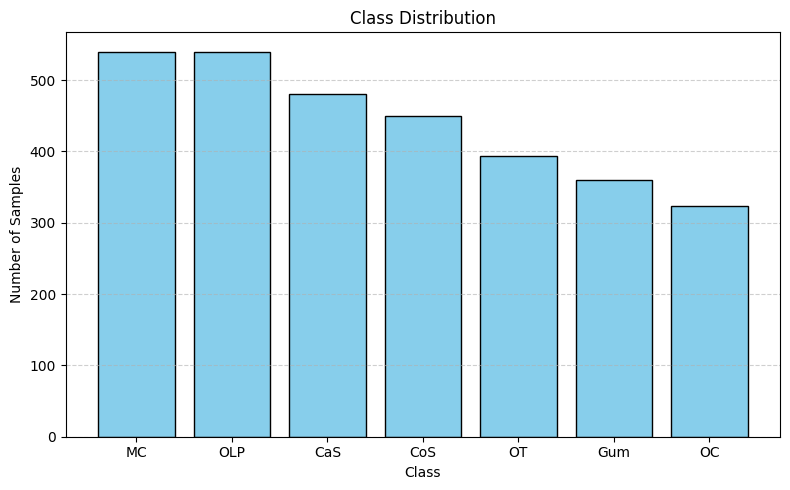

In [10]:
labels2 = list(label_counts_dict.keys())
counts = list(label_counts_dict.values())
plt.figure(figsize=(8, 5))
plt.bar(labels2, counts, color='skyblue', edgecolor='black')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [11]:
label_map = {label: i for i, label in enumerate(sorted(set(train["label"]) | set(val["label"])))}
train["label"] = train["label"].map(label_map)
val["label"] = val["label"].map(label_map)
test["label"] = test["label"].map(label_map)

In [12]:
print("Train labels:", np.unique(train['label']))
print("Val labels:  ", np.unique(val['label']))
print("Test labels:  ", np.unique(test['label']))

Train labels: [0 1 2 3 4 5 6]
Val labels:   [0 1 2 3 4 5 6]
Test labels:   [0 1 2 3 4 5 6]


In [13]:
def apply_augmentations(images):
    augmented_images = []
    for img in images:
        img_uint8 = np.clip(img, 0, 255).astype(np.uint8)
        aug = augment_fn(image=img_uint8)['image']
        aug = aug.astype(np.float32) / 255.0
        augmented_images.append(aug)
    return np.stack(augmented_images)

In [14]:
X_train = apply_augmentations([img * 255.0 for img in train['image'].values])
y_train = np.stack(train['label'].values)
X_val = np.stack(val['image'].values).astype(np.float32)
y_val = np.stack(val['label'].values)
X_test = np.stack(test['image'].values).astype(np.float32)
y_test= np.stack(test['label'].values)

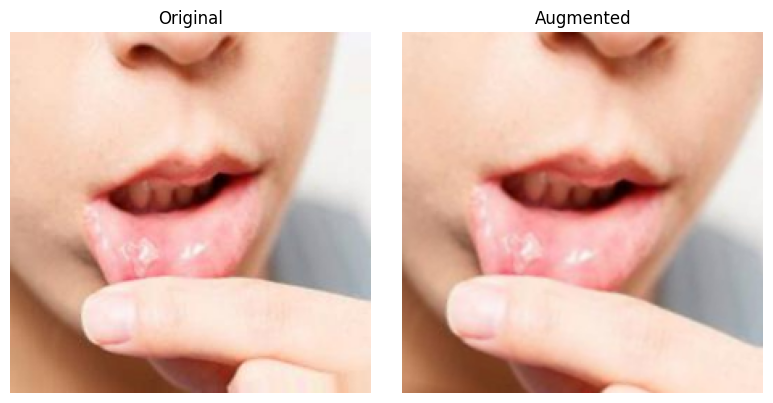

In [15]:
idx = 0
original =(train['image'][idx]* 255).astype(np.uint8)
augmented = (X_train[idx] * 255).astype(np.uint8)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(original)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(augmented)
plt.title("Augmented")
plt.axis("off")

plt.tight_layout()
plt.show()

In [16]:
from keras.utils import to_categorical

y_train_oh = to_categorical(y_train, num_classes=7)
y_val_oh = to_categorical(y_val, num_classes=7)
y_test_oh = to_categorical(y_test, num_classes=7)

In [17]:
print(train.head(1))
print(val.head(1))

                                               image  label
0  [[[0.9882353, 0.8509804, 0.77254903], [0.98823...      0
                                               image  label
0  [[[1.0, 0.94509804, 0.88235295], [1.0, 0.94509...      0


In [18]:
y_train.shape

(3087,)

In [19]:
X_train.shape

(3087, 224, 224, 3)

In [20]:
X_train.shape[1:]

(224, 224, 3)

In [23]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_oh)).shuffle(buffer_size=len(X_train)).batch(8)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val_oh)).batch(8)
test_ds   = tf.data.Dataset.from_tensor_slices((X_test, y_test_oh)).batch(1)

In [24]:
input_shape = (224,224,3)
from keras.applications.efficientnet import EfficientNetB0
with tf.device('/GPU:0'):
    model = EfficientNetB0(
        input_shape=input_shape,
        weights=None,
        classes=7
    )

In [ ]:
sgd = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy','categorical_accuracy'])

In [26]:
model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0

In [27]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "best_model.h5",
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)


In [28]:
hist= model.fit(train_ds, epochs=100,validation_data=val_ds,verbose=1,callbacks=[checkpoint_cb])

Epoch 1/100
386/386 [==============================] - ETA: 0s - loss: 2.6918 - accuracy: 0.2491 - categorical_accuracy: 0.2491
Epoch 1: val_loss improved from inf to 3.62032, saving model to best_model.h5
386/386 [==============================] - 40s 81ms/step - loss: 2.6918 - accuracy: 0.2491 - categorical_accuracy: 0.2491 - val_loss: 3.6203 - val_accuracy: 0.1449 - val_categorical_accuracy: 0.1449
Epoch 2/100
386/386 [==============================] - ETA: 0s - loss: 1.8599 - accuracy: 0.2974 - categorical_accuracy: 0.2974
Epoch 2: val_loss improved from 3.62032 to 2.53169, saving model to best_model.h5
386/386 [==============================] - 26s 68ms/step - loss: 1.8599 - accuracy: 0.2974 - categorical_accuracy: 0.2974 - val_loss: 2.5317 - val_accuracy: 0.2364 - val_categorical_accuracy: 0.2364
Epoch 3/100
386/386 [==============================] - ETA: 0s - loss: 1.6978 - accuracy: 0.3576 - categorical_accuracy: 0.3576
Epoch 3: val_loss improved from 2.53169 to 1.63520, saving

In [29]:

def plot(training_results, validation_results, results_type, model_name):
    fig = plt.figure(figsize=[8, 6])

    plt.plot(training_results, 'r', linewidth=3.0)
    plt.plot(validation_results, 'b', linewidth=3.0)
    plt.legend(['Training ' + results_type, 'Validation ' + results_type], fontsize=18)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel(results_type, fontsize=16)
    #plt.title(results_type + ' of ' + model_name, fontsize=16)


def plot_accuracy(history, model_name):
    plot(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy', model_name)


def plot_loss(history, model_name):
    plot(history.history['loss'], history.history['val_loss'], 'Loss', model_name)

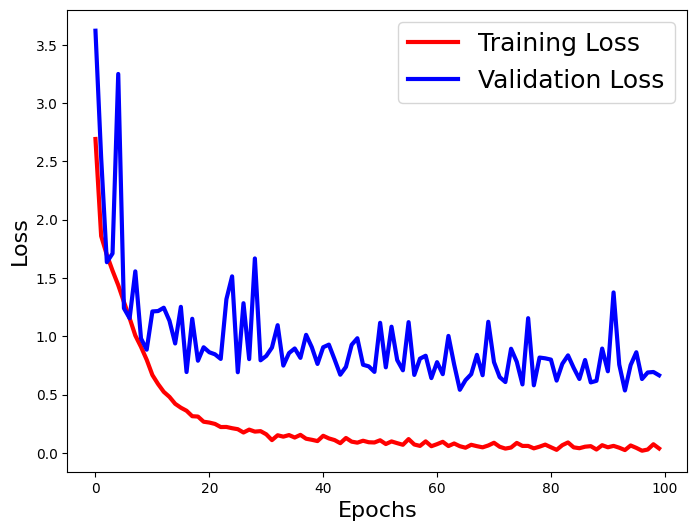

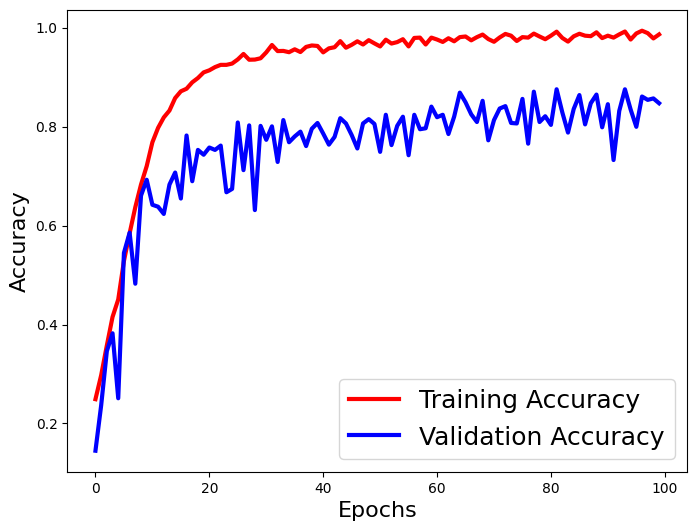

In [30]:
plot_loss(hist, model)
plot_accuracy(hist, model)

In [31]:
from keras.models import load_model
model = load_model("best_model.h5")

In [32]:
metrics = model.evaluate(test_ds, return_dict=True)
for name, value in metrics.items():
    print(f"{name}: {value:.4f}")


1028/1028 [==============================] - 18s 17ms/step - loss: 0.5292 - accuracy: 0.8842 - categorical_accuracy: 0.8842
loss: 0.5292
accuracy: 0.8842
categorical_accuracy: 0.8842
